In [2]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau, MultiplicativeLR
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from tqdm import *
import seaborn as sns

## **The dataset is shown below:**

In [52]:
data_df = pd.read_csv('../data/CreditPrediction.csv')
# removing duplicated datas
data_no_dup = data_df.drop_duplicates() 
# data_no_dup = data_no_dup.fillna(0)
# data_no_dup = pd.get_dummies(data_no_dup, columns=['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category'], drop_first=True, )

# data_no_dup[data_no_dup.isna().any(axis=1)]
# data_no_dup=data_no_dup.dropna()




In [53]:
# plt.boxplot(data_no_dup['Credit_Limit'], vert=False)
# plt.title("Boxplot of the sample after treating the outliers")
# plt.xlabel("Sample")

## **Handling Outliers:**

In [54]:
# def detect_outliers_iqr(data_col):

#     median = np.median(data_col)

#     outliers = []
#     data_sorted = sorted(data_col)
#     q1 = np.percentile(data_sorted, 25)
#     q3 = np.percentile(data_sorted, 75)
#     # print(q1, q3)
#     IQR = q3-q1
#     lwr_bound = q1-(1.5*IQR)
#     upr_bound = q3+(1.5*IQR)
#     # print(lwr_bound, upr_bound)
#     for d in data_sorted: 
#         if (d<lwr_bound or d>upr_bound):
#             index = data_col.loc[data_col == d].indexs
#             for i in index:
#                 data_col[i] = median
#             outliers.append(i)
#     return outliers# Driver code


# for col in data_no_dup:
#     if col not in (data_no_dup.select_dtypes(include='object').columns):
#         sample_outliers = detect_outliers_iqr(data_no_dup[col])
#         print(f"COL: {col} || Outliers from IQR method: ", sample_outliers)

Text(0.5, 0, 'Sample')

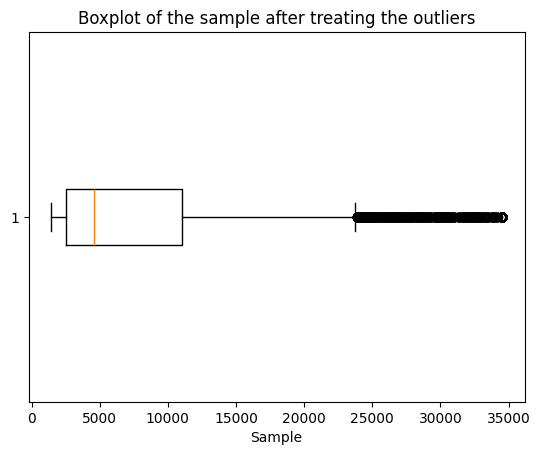

In [55]:
plt.boxplot(data_no_dup['Credit_Limit'], vert=False)
plt.title("Boxplot of the sample after treating the outliers")
plt.xlabel("Sample")


## **Done Outliers:**

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

1.6673134968834804
(10132, 20)


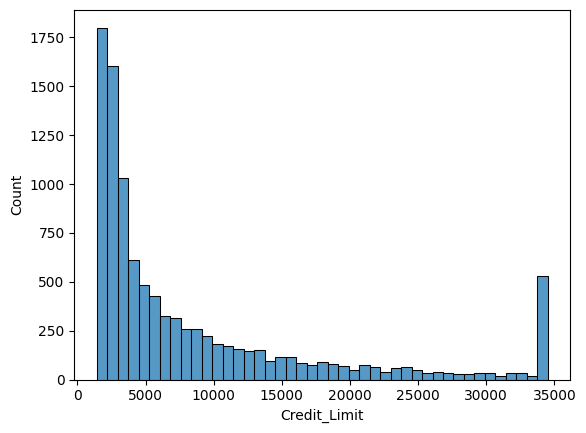

(5062, 20)
0.7611011569253084


/tmp/ipykernel_4181/1595739727.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_no_dup.drop(index,inplace=True)


Text(0.5, 0, 'Sample')

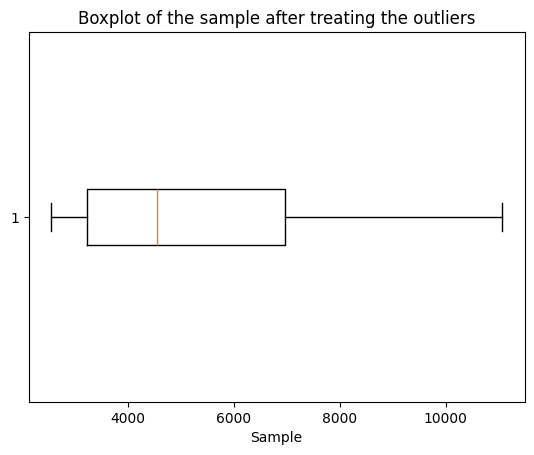

In [57]:
print(data_no_dup['Credit_Limit'].skew())
print(data_no_dup.shape)
sns.histplot(data=data_no_dup,x="Credit_Limit")
plt.show()

upper=data_no_dup['Credit_Limit'].quantile(0.25)
lower=data_no_dup['Credit_Limit'].quantile(0.75)

#print(upper,lower)

index=data_no_dup[(data_no_dup['Credit_Limit']>=lower)|(data_no_dup['Credit_Limit']<=upper)].index

data_no_dup.drop(index,inplace=True)
print(data_no_dup.shape)

data_no_dup['Credit_Limit'].describe()
print(data_no_dup['Credit_Limit'].skew())
plt.boxplot(data_no_dup['Credit_Limit'], vert=False)
plt.title("Boxplot of the sample after treating the outliers")
plt.xlabel("Sample")



In [58]:
def fix_missing_values(df):
    # Identify numerical and categorical columns
    num_cols = df.select_dtypes(exclude='object').columns
    cat_cols = df.select_dtypes(include='object').columns

    # Create transformers for numerical and categorical data
    num_transformer = IterativeImputer()
    cat_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Combine transformers into a ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_transformer, num_cols),
            ('cat', cat_transformer, cat_cols)
        ]
    )

    # Apply the transformations
    preprocessed_data = preprocessor.fit_transform(data_no_dup)

    # Convert the result back to a DataFrame (optional)
    preprocessed_df = pd.DataFrame(preprocessed_data)

    # Display the preprocessed DataFrame
    return preprocessed_df

In [59]:
X = data_no_dup.drop('Credit_Limit', axis=1)
y = data_no_dup['Credit_Limit']

X = fix_missing_values(X)


/home/kianoosh/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: [13]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=45)
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pca = PCA(.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
X_train.shape

(3391, 35)

In [61]:
def select_features(X_train, y_train, X_test):
 fs = SelectKBest(score_func=mutual_info_regression, k=24)
 fs.fit(X_train, y_train)
 X_train_fs = fs.transform(X_train)

 X_test_fs = fs.transform(X_test)
 return X_train_fs, X_test_fs, fs


In [62]:

X_train_fs, X_test_fs, fs = select_features(X_train_pca, y_train, X_test_pca)

Feature 0: 0.088264
Feature 1: 0.046551
Feature 2: 0.003420
Feature 3: 0.092882
Feature 4: 0.017344
Feature 5: 0.026649
Feature 6: 0.013898
Feature 7: 0.003083
Feature 8: 0.000000
Feature 9: 0.035798
Feature 10: 0.015870
Feature 11: 0.000000
Feature 12: 0.012392
Feature 13: 0.008345
Feature 14: 0.000989
Feature 15: 0.001658
Feature 16: 0.018274
Feature 17: 0.000000
Feature 18: 0.000000
Feature 19: 0.000000
Feature 20: 0.003420
Feature 21: 0.000000
Feature 22: 0.000000
Feature 23: 0.000000
Feature 24: 0.000000
Feature 25: 0.000000
11


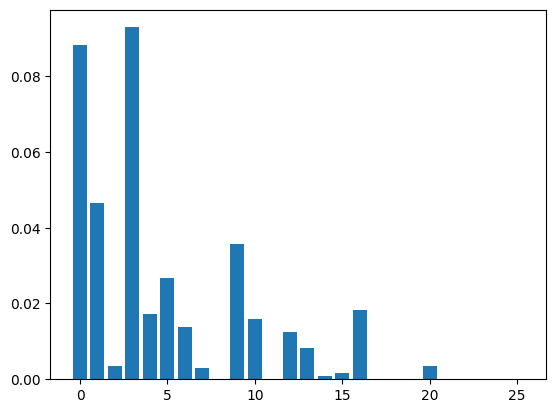

In [63]:
# what are scores for the features
ignr_cnt = 0
for i in range(len(fs.scores_)):
 if (fs.scores_[i] < 0.0015):
  ignr_cnt +=1
 print('Feature %d: %f' % (i, fs.scores_[i]))
print(ignr_cnt)
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [64]:
X_train_fs = np.array(X_train_fs) 
X_test_fs = np.array(X_test_fs) 

y_train = np.array(y_train) 
y_test = np.array(y_test) 



In [65]:
X_train_fs = torch.from_numpy(X_train_fs.astype(np.float32))
X_test_fs = torch.from_numpy(X_test_fs.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

X_train = torch.from_numpy(X_train.astype(np.float32))


y_train = y_train.view(y_train.shape[0], 1)
y_test = y_test.view(y_test.shape[0], 1)

_, n_features = X_train_fs.shape




In [66]:
X_train_fs  = X_train_fs.to(device)
y_train = y_train.to(device)
X_train = X_train.to(device)

X_test_fs  = X_test_fs.to(device)
y_test = y_test.to(device)

In [67]:
class BankDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = (self.data[idx], self.targets[idx])
        return sample

In [68]:
dataset = BankDataset(X_train_fs, y_train)
dataloader = DataLoader(dataset=dataset, batch_size=64, shuffle=True)


In [69]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Model, self).__init__()
        self.dropout = nn.Dropout(0.2)
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.leaky_reLu = nn.LeakyReLU()
        self.reLu = nn.ReLU()

        self.linear2 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out = self.dropout(x)

        out = self.linear1(out)
        out = self.leaky_reLu(out)
        out = self.linear2(out)
        # out = self.sigmoid(out)
        return out

In [90]:
class Model2(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Model2, self).__init__()
        self.dropout = nn.Dropout(0.2)
        self.linear1 = nn.Linear(input_size, 25)

        
        self.linear2 = nn.Linear(25, 12)
        self.linear3 = nn.Linear(12, 1)
        self.linear4 = nn.Linear(12, 1)


        self.leaky_reLu = nn.LeakyReLU()
        self.reLu = nn.ReLU()

        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        out = self.dropout(x)
        out = self.linear1(out)
        out = self.leaky_reLu(out)
        out = self.linear2(out)
        out = self.leaky_reLu(out)
        out = self.linear3(out)
        # ut = self.leaky_reLu(out)
        # out = self.linear4(ouot)
        # out = self.sigmoid(out)
        return out

In [91]:
model = Model2(n_features , 13)
model = model.to(device)

n_features

24

In [92]:
num_epochs = 100000
learning_rate = 0.0001
criterion = nn.MSELoss()  ####################################################################
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lmbda = lambda epoch: 0.95

scheduler = MultiplicativeLR(optimizer, lr_lambda=lmbda)
lambda_reg = 0.1
loss = 0



for epoch in range(num_epochs):
    # Forward pass and loss
    # model.zero_grad()
    y_pred = model(X_train_fs)
    loss = criterion(y_pred, y_train)

    # TODO Validation
    # TODO Bath
    # TODO 2 for

    # # Compute L2 regularization term
    l2_reg = torch.tensor(0.)
    l2_reg = l2_reg.to(device)

    for param in model.parameters():
        l2_reg += torch.norm(param)
    
    # Add regularization term to loss
    loss += lambda_reg * l2_reg

    # Backward pass and update

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    # zero grad before new step

    if (epoch+1) % 1000 == 0:
        print(f"epoch: {epoch+1}, loss = {loss.item():.4f} || "
              f"lr: {optimizer.state_dict()['param_groups'][0]['lr']:.7f}")
    if (epoch+1) % 5000 == 0 and epoch > 20000:
        scheduler.step()
    



epoch: 1000, loss = 33328870.0000 || lr: 0.0001000
epoch: 2000, loss = 33081180.0000 || lr: 0.0001000
epoch: 3000, loss = 32572374.0000 || lr: 0.0001000
epoch: 4000, loss = 31775438.0000 || lr: 0.0001000
epoch: 5000, loss = 30679530.0000 || lr: 0.0001000
epoch: 6000, loss = 29293210.0000 || lr: 0.0001000
epoch: 7000, loss = 27634972.0000 || lr: 0.0001000
epoch: 8000, loss = 25689080.0000 || lr: 0.0001000
epoch: 9000, loss = 23515378.0000 || lr: 0.0001000
epoch: 10000, loss = 21215802.0000 || lr: 0.0001000
epoch: 11000, loss = 18746236.0000 || lr: 0.0001000
epoch: 12000, loss = 16348328.0000 || lr: 0.0001000
epoch: 13000, loss = 13995982.0000 || lr: 0.0001000
epoch: 14000, loss = 11888973.0000 || lr: 0.0001000
epoch: 15000, loss = 9803570.0000 || lr: 0.0001000
epoch: 16000, loss = 8261920.5000 || lr: 0.0001000
epoch: 17000, loss = 6989546.0000 || lr: 0.0001000
epoch: 18000, loss = 6237938.5000 || lr: 0.0001000
epoch: 19000, loss = 5794911.0000 || lr: 0.0001000
epoch: 20000, loss = 54275

In [94]:
from sklearn.metrics import mean_squared_error
with torch.no_grad():
    y_predicted = model(X_test_fs)
    # y_predicted = np.array(y_predicted)
     
    MSE = mean_squared_error(y_predicted.cpu(), y_test.cpu())
MSE

4742228.5

In [95]:
X_train_pca.shape

(3391, 26)